In [1]:
from skimage.io import imread, imsave
from skimage import data, color
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import math
from osgeo import gdal, osr

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
forest1 = np.reshape([1189, 3396], (2, 1))
forest2 = np.reshape([1197, 3962], (2, 1))
forest3 = np.reshape([1147, 2948], (2, 1))
forest4 = np.reshape([1166, 4684], (2, 1))
forest5 = np.reshape([1159, 4152], (2, 1))
forest = np.hstack((forest1, forest2, forest3, forest4, forest5))
soil1 = np.reshape([2218, 3730], (2, 1))
soil2 = np.reshape([1792, 2510], (2, 1))
soil3 = np.reshape([3008, 4328], (2, 1))
soil4 = np.reshape([2700, 3332], (2, 1))
soil5 = np.reshape([1506, 2266], (2, 1))
soil6 = np.reshape([1359, 5352], (2, 1))
soil7 = np.reshape([3586, 3518], (2, 1))
soil8 = np.reshape([2384, 2478], (2, 1))
soil9 = np.reshape([1771, 2708], (2, 1))
soil = np.hstack((soil1, soil2, soil3, soil4, soil5, soil6, soil7, soil8, soil9))

In [6]:
def mSMA(image):
  #frequency_bands = number of different frequency bands being used
  #(currently Red and Near Infrared)
  frequency_bands = 2

  #ground_cover = number of different types of ground cover
  #(currently forest and soil)
  ground_cover = 2
  nrows, ncols = image.shape[0], image.shape[1]

  #output = 3D array containing the percentage of forest and percentage of soil in each pixel
  #ouput[:, :, 0] = forest
  #ouput[:, :, 1] = soil
  output = np.zeros((nrows, ncols, ground_cover))

  #rmse = 2D array containing the root mean square error between each actual pixel
  #and the modeled pixel

  #Various modeled pixel matrices are tried using the various pure spectra in the previous
  #cell, and the one with the lowest RMSE value is used
  rmse = np.zeros((nrows, ncols))

  for i in range(nrows):
    for j in range(ncols):
      #curr = R + NIR values of current pixel
      curr = np.array(image[i, j, :])
      curr = np.reshape(curr, (frequency_bands, 1))

      min_rmse = float('inf')
      best_f = []

      for k in range(len(forest[0])):
        for l in range(len(soil[0])):
          #M = joint_array of pure spectra (frequency bands x types of ground cover)
          M = np.hstack((np.reshape(forest[:, k], (frequency_bands, 1)), np.reshape(soil[:, l], (frequency_bands, 1))))
          #f = column vector, proportion of pixel explained by the pure spectra in M (2 elements)
          f = np.linalg.solve(M, curr)

          f[f < 0] = 0
          if np.sum(f) > 1:
            f = f / np.sum(f)

          #r = expected pixel value calculated from r = Mf
          r = np.dot(M, f)

          #Calculating RMSE, and iterating over the number of frequency bands
          diff = 0
          for k in range(frequency_bands):
            #diff = difference between expected and actual value
            diff += (curr[k] - r[k]) * (curr[k] - r[k])
          curr_rmse = math.sqrt(diff / frequency_bands)

          if curr_rmse < min_rmse:
            min_rmse = curr_rmse
            best_f = f

        output[i,j,:] = np.reshape(best_f, (2,))
        rmse[i, j] = min_rmse
        np.append(rmse, min_rmse)

  return rmse, output

<ipython-input-6-60aef8b570d8>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  curr_rmse = math.sqrt(diff / frequency_bands)


Image in the red frequency band:


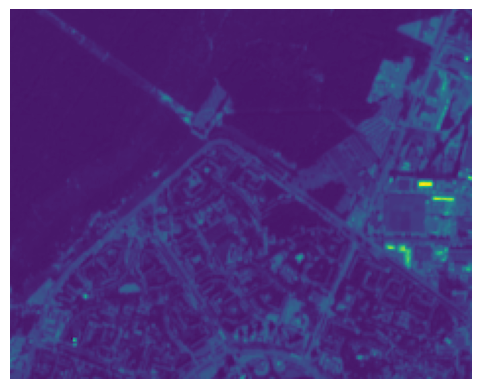

Image in the near infrared frequency band:


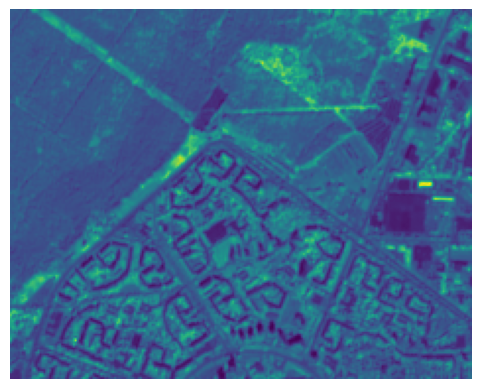

Forest percentage:


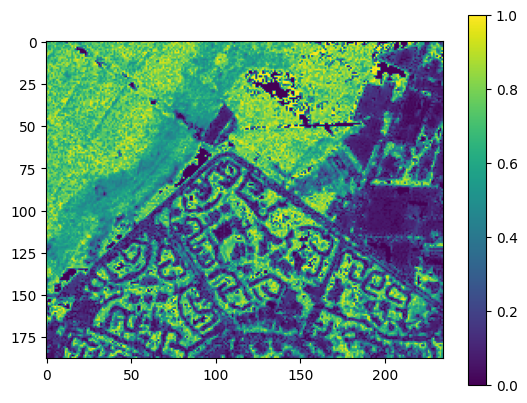

Open soil/asphalt percentage:


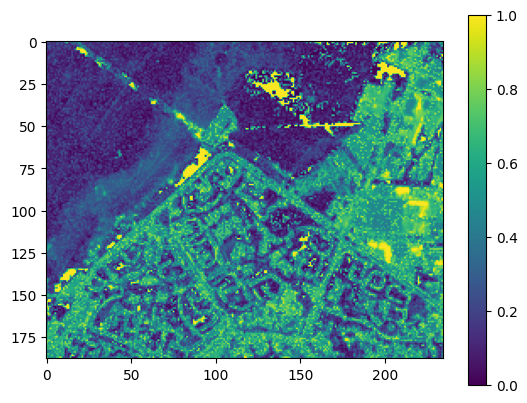

In [8]:
image = imread('/content/gdrive/MyDrive/EDI Prakse/RNIRv3Test.tif')
#Two frequency bands (R & NIR), two types of ground cover (forest + soil)
rmse, output = mSMA(image)
print('Image in the red frequency band:')
plt.imshow(image[:,:,0])
plt.axis('off')
plt.show()
print('Image in the near infrared frequency band:')
plt.imshow(image[:, :, 1])
plt.axis('off')
plt.show()
print('Forest percentage:')
plt.imshow(output[:,:,0])
plt.colorbar()
plt.show()
print('Open soil/asphalt percentage:')
plt.imshow(output[:,:,1])
plt.colorbar()
plt.show()

In [ ]:
def array2raster(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, array, epsg, typedef):
        """
            Function for saving array as GeoTiff.
            Args:
                newRasterfn: filename of the GeoTiff
                rasterOrigin: map coordinates of upper left corner of the image.
                pixelWidth: in meters.
                pixelHeight: in meters.
                array: array to save as GeoTiff.
                epsg: code for CRS
                bands: number of array layers.

        """
        if len(array.shape) > 2:
            bands = array.shape[2]
        else:
            bands = 1
        cols = array.shape[1]
        rows = array.shape[0]
        originX = rasterOrigin[0]
        originY = rasterOrigin[1]
        driver = gdal.GetDriverByName('GTiff')
        outRaster = driver.Create(newRasterfn, cols, rows, bands, typedef)
        print(newRasterfn, cols, rows, bands, rasterOrigin, pixelHeight, pixelWidth)
        outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
        if bands == 1:
            outband = outRaster.GetRasterBand(1)
            outband.WriteArray(array)
        else:
            for i in range(0, bands):
                outband = outRaster.GetRasterBand(i + 1)
                outband.WriteArray(array[:, :, i])
        outRasterSRS = osr.SpatialReference()
        outRasterSRS.ImportFromEPSG(epsg)
        outRaster.SetProjection(outRasterSRS.ExportToWkt())
        outband.FlushCache()
def get_geo_info(im_fn):
        """
        Getting geo transform information from GeoTiff.
        INPUT: im_fn - filename of the GeoTiff file.
        RETURNS:
            rasterOrigin - raster origin in coordinate reference system
            px, py - spatial resolution in x and y directions
            epsg - EPSG code of coordinate reference system
        """
        imd = gdal.Open(im_fn)
        projection = imd.GetProjection()
        srs = osr.SpatialReference()
        srs.ImportFromWkt(projection)
        try:
            epsg = int(srs.GetAttrValue("AUTHORITY", 1))
        except:
            epsg = 3059
        geo_transform = imd.GetGeoTransform()
        rasterOrigin = [geo_transform[0], geo_transform[3]]
        px = geo_transform[1]
        py = geo_transform[5]
        return rasterOrigin, px, py, epsg

In [ ]:
#original_im_fn = name of the initial image from which the results were formed
#Needs to be a GeoTiff file which can be read in by QGIS
original_im_fn = r'/content/gdrive/MyDrive/EDI Prakse/RNIRv3Test.tif'
og = imread('/content/gdrive/MyDrive/EDI Prakse/forest_percent_results_RNIRv3Test.tif')
#GeoTiff tags are read in from the original image
ro,rx,ry,epsg = get_geo_info(original_im_fn)
print(epsg)
#Name of the new GeoTiff file with coordinates
new_im = r'/content/gdrive/MyDrive/EDI Prakse/forest_percent_results_RNIRv3Test_WithCoordinates.tif'
array2raster(new_im, ro, rx, ry, og, epsg, gdal.GDT_Float32)